In [1]:
library(pracma)
library(plotly)
library(matrixcalc)
library(viridis)
library(fields)
library(Matrix)
library(clusterGeneration)
#library(wordspace)
#load source file
src.path <- "../src"
source(paste(src.path, "DataGenerationProcess", "synth_basis.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_data.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_graph.R", sep="/"))
source(paste(src.path, "DataGenerationProcess", "synth_linearop.R", sep="/"))

source(paste(src.path, "Utility", "R2python.R", sep="/"))
source(paste(src.path, "Estimation", "basis_estimation.R", sep="/"))
source(paste(src.path, "Utility", "utility.R", sep="/"))
source(paste(src.path, "Estimation", "cca_estimation.R", sep="/"))

Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


Attaching package: ‘Matrix’


The following object is masked from ‘package:spam’:

    det


The following objec

In [2]:


estimate.cca.basis_expansion <- function(obj1, obj2, ncan){
    #obj, obj2:fd object
    stopifnot(dim(obj1$coefs)[2] == dim(obj2$coefs)[2])
    n <- dim(obj1$coefs)[2]
    d1 <- obj1$coefs#t(inprod(obj1, obj1$basis))
    d2 <- obj2$coefs#t(inprod(obj2, obj2$basis))

    cov1  <- (d1 %*% t(d1)) / n
    cov2  <- (d2 %*% t(d2)) / n
   
    cov12 <- (d1 %*% t(d2)) / n

    
    inv_cov1.s <- solve( cov1 )

    #inv_cov1.s <- solve( cov1 )
    est.r <- eigen(inv_cov1.s , symmetric=TRUE)
    
    inv_cov1.s <- est.r$vectors %*% diag(sqrt(est.r$values)) %*% t(est.r$vectors)



    inv_cov2.s <- solve( cov2 )

    est.r <- eigen(inv_cov2.s,  symmetric=TRUE)
    inv_cov2.s <- est.r$vectors %*% diag(sqrt(est.r$values)) %*% t(est.r$vectors)
    
    
    m <- (inv_cov1.s %*% cov12) %*% inv_cov2.s
    m <- m %*% t(m)
    
    eigen.m <- eigen(m, symmetric=TRUE)
    print("canonical correlation values:")
    print(eigen.m$values)
    inv_corr <- diag(1. / sqrt(eigen.m$values[1:ncan]))
 
    A1 <- inv_cov1.s  %*% eigen.m$vectors[,1:ncan] %*% inv_corr
    print(dim(A1))
    A2 <- inv_cov2.s %*% inv_cov2.s %*% t(cov12) %*% A1 

    return(list("A1"=t(A1), "A2"=t(A2)))

}

In [3]:
n <- 1000
p <- 50
k.gen <- 10
M <- 2
obs.time <- seq(0,1,1/50)
## be careful for the choice of the number of basis function 
## fourier basis: km must be odd
## bspline basis km>4
km.gen <- c(5,15)

Apinv_list <- list()
A_list <- list()
N_list <- list()
basis.m_list <- list()
true.basis_list <- list()
true.values_list <- list()

In [4]:
#generate data from the graph

omega <- synth.omega.tridiag1(p, k.gen)#, drop=0.1)
#ensure that the diagonal values are all 1

cov <- solve(omega)
B_list <- utility.graph2B(omega,p)
utility.print.graph.info(B_list,p,1e-2)


   0    5 
2256  194 
[1] "sparsity: 4"
[1] "alpha: 3"


In [5]:



for(m in 1:M){
    Am <- synth.linear_op.sparse_orthogonal(k.gen, km.gen[m], 3, scale=.5)
    Am <- t(t(Am) %*% diag(.2*((1:k.gen))+1)) #this is to make the singular values distinct
    #print(dim(Am))
    A_list[[m]] <- Am


    Am_svd <- svd(Am)
    id <- which(Am_svd$d > 1e-5)
    #print(Am_svd$d)
    Am_inv <- t(Am_svd$u[,id] %*% diag(1./Am_svd$d[id]) %*% t(Am_svd$v[,id]))
    
    Apinv_list[[m]] <- Am_inv
    

    
    Acov <- kronecker(diag(p), Am_inv) %*% cov%*% t(kronecker(diag(p),Am_inv))
    eig_A <- eigen(Acov, symmetric = TRUE)
    min_eigA <- min(eig_A$values)
    max_eigA <- max(eig_A$values)

    
    density = 0.04*m
    
    x <- rsparsematrix(p, p, density, 
              symmetric = FALSE)
    y <- as.matrix((x+t(x))/2)
    y2 <- t(matrix(rep(y, each=km.gen[m]), ncol=p))
    y3 <- t(matrix(rep(y2, each=km.gen[m]), ncol= p*km.gen[m]))

    eig_y <- eigen(y3, symmetric = TRUE) 
    id <- which(eig_y$values > 1e-5)
    #print(paste("rank:",length(id)))
    #compute the pqsudo inverse
    y4 <- eig_y$vectors[,id] %*% diag(1./eig_y$values[id]) %*% t(eig_y$vectors[,id])
    eig_y4 <- eigen(y4, symmetric=TRUE)
    eig_y4$values <- eig_y4$values / max(eig_y4$values) * (.01*max_eigA)
    y5 = eig_y4$vectors %*% diag(eig_y4$values) %*% t(eig_y4$vectors)
    #print(paste("max eigen N", max(eig_y4$values)))
    #normalize the signal
    N_list[[m]]  <- y5 + diag(p*km.gen[m])*.1

    if (m == 1){
        basis.m_list[[m]] <- synth.fourier.bases.m(obs.time, km.gen[m])
    } else{
        basis.m_list[[m]] <- synth.bspline.bases.m(obs.time, km.gen[m])
    }


    
    if(m == 1){
        pre1 <- solve(Acov+N_list[[m]])
    }

    pre <- pinv(Acov+N_list[[m]])

    #par(bg="white")
    #image.plot(N_list[[m]] ,col=viridis(128), main='noise mtrix')   
    true <- pinv(Acov)
    max_div <- max(pre,true)

    #par(bg="white")
    #image.plot(abs(pinv(Acov)-)/max_div ,col=viridis(128), main='precision (difference)')
    #print(paste("min difference (ratio)", min(abs(pre-true))/max_div))
    #print(paste("max difference (ratio)", max(abs(pre-true))/max_div))
    print('graph with noise')
    B_list <- utility.graph2B(solve(Acov+N_list[[m]]),p)
    utility.print.graph.info(B_list,p,1e-2)
    print('graph without noise')
    B_list <- utility.graph2B(pinv(Acov),p)
    
    utility.print.graph.info(B_list,p,1e-2)
    #par(bg='white')
    #image.plot(solve(Acov+N_list[[m]]) ,col=viridis(128), main='precision (add noise)')
    
}
#par(bg="white")
#image.plot(abs(pre1-solve(Acov+N_list[[m]])), col=viridis(128), main='difference of two precesion')
#print(paste("min difference", min(abs(pre1-solve(Acov+N_list[[m]])))))
#print(paste("max difference", max(abs(pre1-solve(Acov+N_list[[m]])))))

[1] "graph with noise"

   4    5 
 110 2340 
[1] "sparsity: 49"
[1] "alpha: 5"
[1] "graph without noise"

   3    4    5 
   8  158 2284 
[1] "sparsity: 49"
[1] "alpha: 5"
[1] "graph with noise"

   2    3    4    5 
   2  304 1835  309 
[1] "sparsity: 49"
[1] "alpha: 15"
[1] "graph without noise"

   0    5 
2256  194 
[1] "sparsity: 4"
[1] "alpha: 14"


In [202]:
#generate data phase
data <- synth.data_from_graph(n, p, cov, basis.m_list, Apinv_list, N_list, dependent=TRUE, addnoise=FALSE)
concate_data <- list()
for(m in 1:M){
        dm <- data[[m]][,1,]
    for(i in 2:p){
        dm <- rbind(dm, data[[m]][,p,])
    }
    concate_data[[m]] <- dm
}

fourier.basis1 <- create.fourier.basis(rangeval=c(0,1), nbasis=km.gen[1])
d1 <-Data2fd(argvals=obs.time, y=t(concate_data[[1]]), basisobj=fourier.basis1)
#data modality 2
bspline.basis2 <- create.bspline.basis(rangeval=c(0,1), nbasis=km.gen[2])
d2 <-Data2fd(argvals=obs.time, y=t(concate_data[[2]]), basisobj=bspline.basis2)



[1] "Generating data from modality 1"
[1] "Generating data from modality 2"


In [204]:
cca.r.est <- estimate.cca.basis_expansion(d1, d2, 5)

[1] "canonical correlation values:"
[1] 0.9060432 0.8255467 0.7545984 0.7506008 0.7070227
[1] 5 5


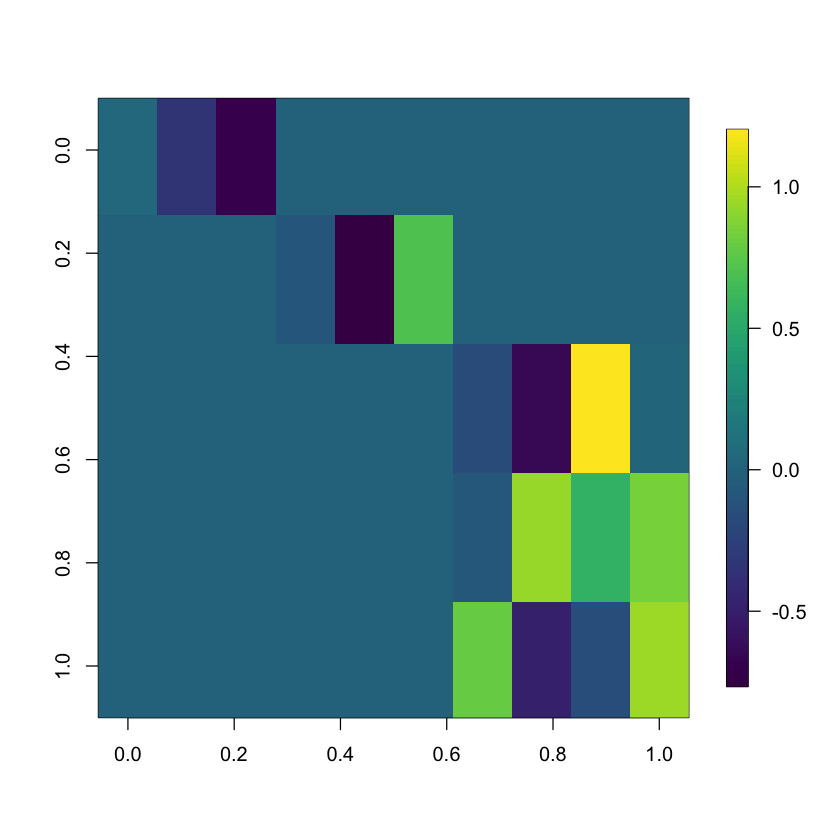

[1] 5 5


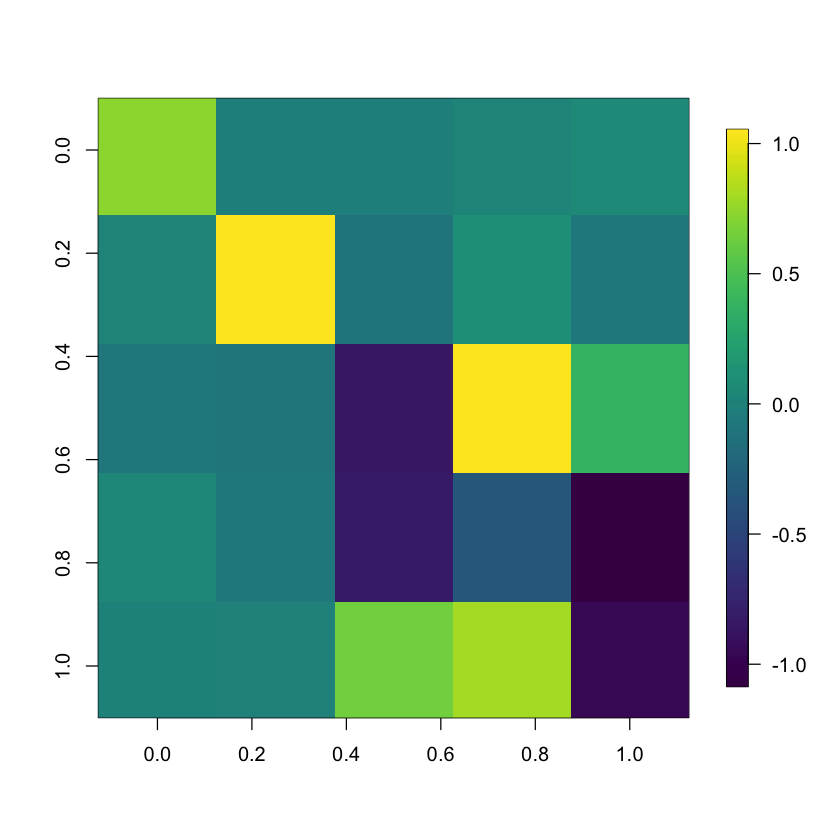

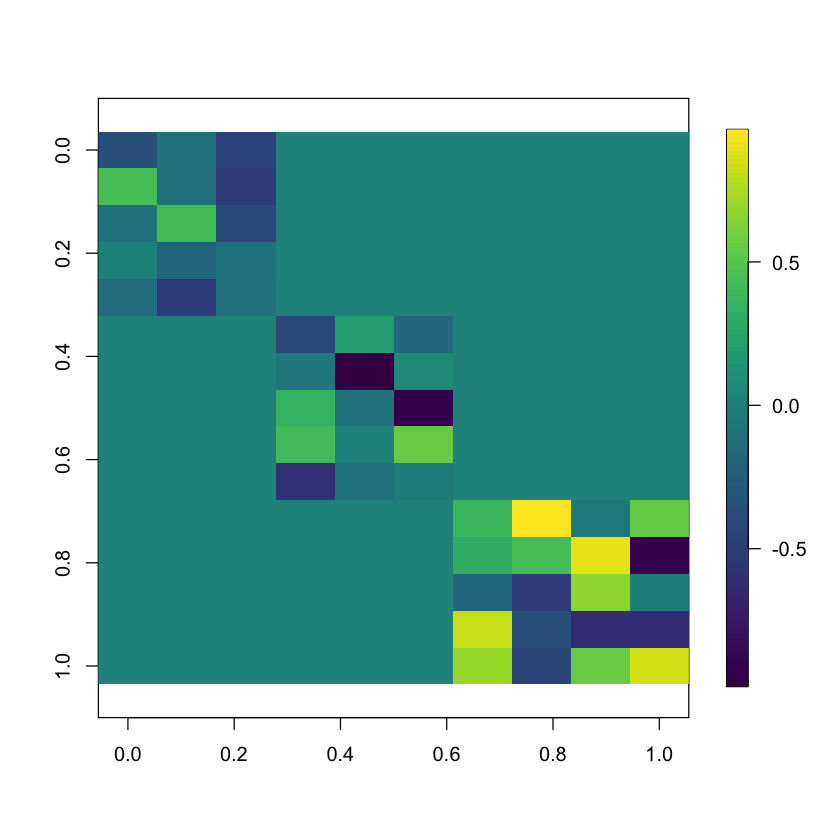

[1]  5 15


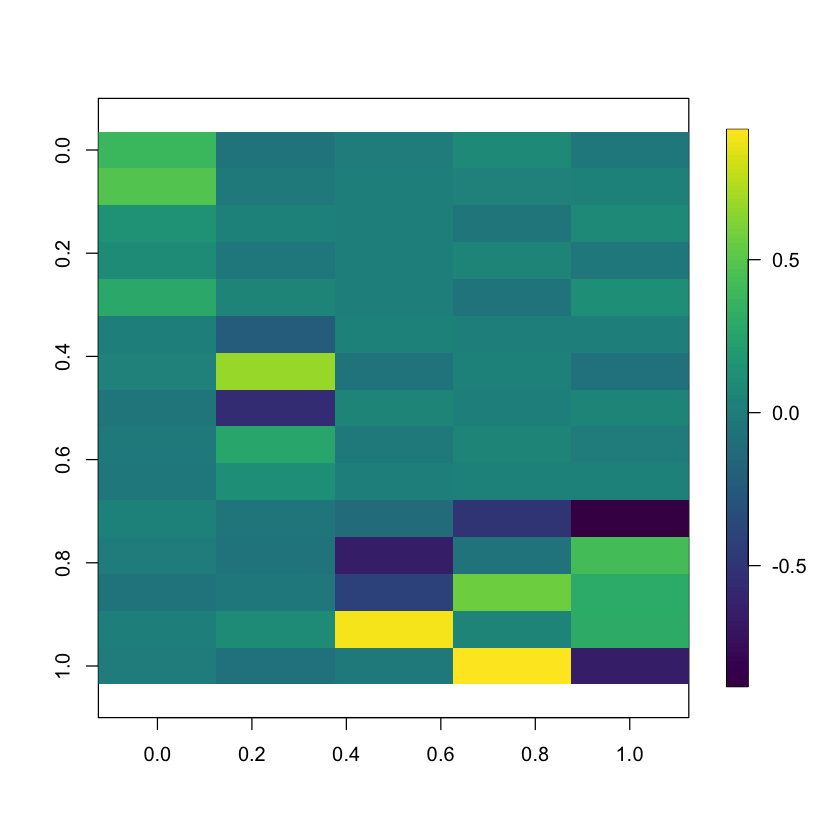

In [208]:

image.plot(A_list[[1]],ylim=c(1.1,-0.1),col=viridis(128))
image.plot(cca.r.est$A1,ylim=c(1.1,-0.1),col=viridis(128))
print(dim(cca.r.est$A1))

image.plot(A_list[[2]],ylim=c(1.1,-0.1),col=viridis(128))
image.plot(cca.r.est$A2,ylim=c(1.1,-0.1),col=viridis(128))
print(dim(cca.r.est$A2))